In [1]:
# Cell 1: Load libraries and saved model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

import joblib

# Load the trained best LDA model from notebook 3
best_lda = joblib.load("best_lda_model.pkl")

# Load processed test data
df = pd.read_csv(r"C:\Users\nimak\Documents\Projects\bank-marketing-classification\data\bank_marketing_processed.csv")

# Reconstruct feature matrix and target
X = df.drop('y', axis=1)
y = df['y']

# Recreate the same train-test split and drop highly correlated columns
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Drop the same correlated features from notebook 3 (hardcoded here for reproducibility)
to_drop = ['euribor3m', 'default_unknown', 'housing_yes', 'loan_unknown', 'contact_telephone']
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)


Optimal threshold: 0.21
Best F1-score at optimal threshold: 0.6258


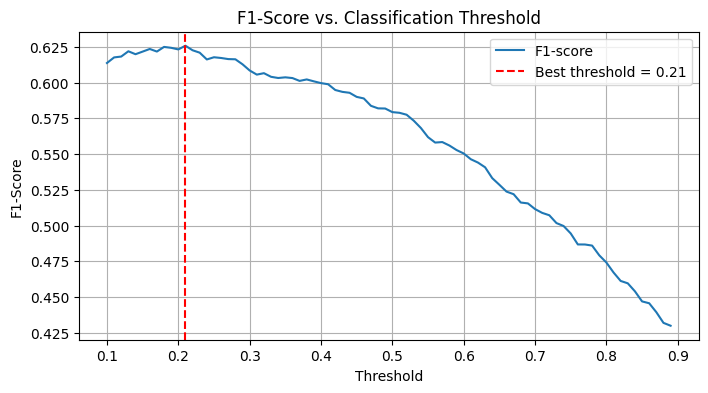


Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7310
           1       0.56      0.71      0.63       928

    accuracy                           0.90      8238
   macro avg       0.76      0.82      0.79      8238
weighted avg       0.92      0.90      0.91      8238



In [27]:
# Cell 2: Optimize the threshold for classification

# Predict class probabilities for the positive class (class 1 = 'yes')
y_probs = best_lda.predict_proba(X_test)[:, 1]

# Evaluate different thresholds to maximize F1-score
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Find threshold that gives highest F1
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {best_thresh:.2f}")
print(f"Best F1-score at optimal threshold: {max(f1_scores):.4f}")

# Plot F1-score vs. threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label="F1-score")
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Best threshold = {best_thresh:.2f}')
plt.title("F1-Score vs. Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True)
plt.show()

# Final prediction using optimal threshold
y_pred_opt_thresh = (y_probs >= best_thresh).astype(int)
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt_thresh))


Classification Report (Voting Classifier):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.68      0.45      0.54       928

    accuracy                           0.91      8238
   macro avg       0.81      0.71      0.75      8238
weighted avg       0.90      0.91      0.91      8238



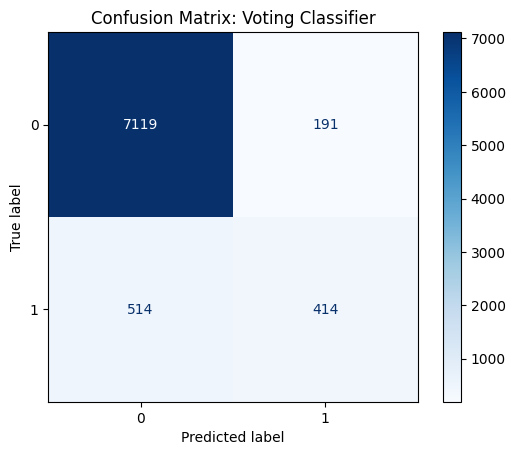

In [16]:
# Cell 3: Voting classifier with LDA, Logistic Regression, and SVM

# Initialize models
logreg = LogisticRegression(max_iter=1000)
svm = SVC(kernel='linear', probability=True)
lda = best_lda  # From earlier

# Combine models into a soft voting ensemble
voting = VotingClassifier(estimators=[
    ('lda', lda),
    ('logreg', logreg),
    ('svm', svm)
], voting='soft')

# Fit the ensemble
voting.fit(X_train, y_train)

# Predict and evaluate
y_pred_voting = voting.predict(X_test)
print("Classification Report (Voting Classifier):")
print(classification_report(y_test, y_pred_voting))

cm = confusion_matrix(y_test, y_pred_voting)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Voting Classifier")
plt.show()


Classification Report (Margin-Based Refinement):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.67      0.47      0.55       928

    accuracy                           0.91      8238
   macro avg       0.80      0.72      0.75      8238
weighted avg       0.90      0.91      0.91      8238



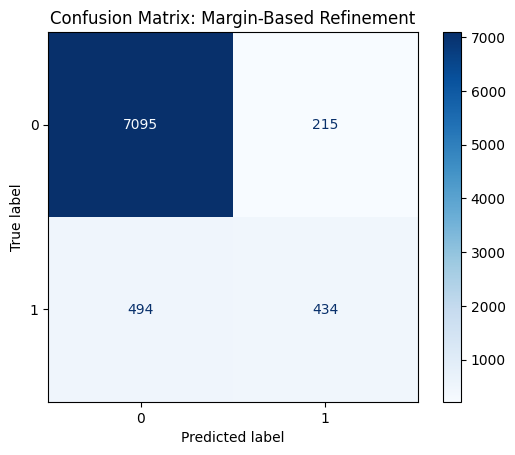

In [17]:
# Cell 4: Margin-based refinement for LDA

# Use prediction probabilities
probs = best_lda.predict_proba(X_test)
margin = np.abs(probs[:, 1] - 0.5)  # Distance from decision boundary

# Set a "margin zone" (near decision boundary)
margin_threshold = 0.1
uncertain_indices = np.where(margin < margin_threshold)[0]

# Copy predictions
y_pred_margin = best_lda.predict(X_test)

# Flip labels in uncertain zone to simulate rule-based refinement
y_pred_margin[uncertain_indices] = 0  # E.g., be more conservative

print("Classification Report (Margin-Based Refinement):")
print(classification_report(y_test, y_pred_margin))

cm = confusion_matrix(y_test, y_pred_margin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Margin-Based Refinement")
plt.show()


Classification Report (Margin-Based Refinement):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.67      0.47      0.55       928

    accuracy                           0.91      8238
   macro avg       0.80      0.72      0.75      8238
weighted avg       0.90      0.91      0.91      8238



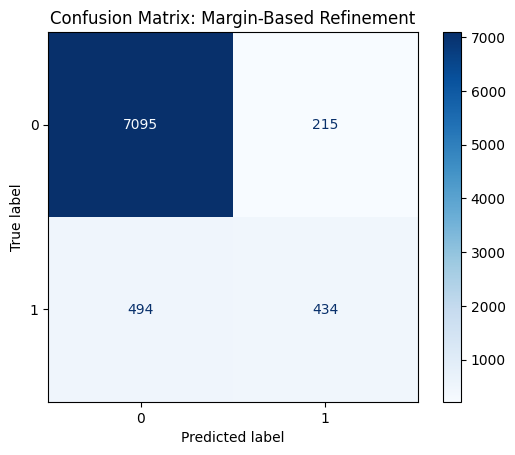

In [19]:
# Cell 4: Margin-based refinement for LDA

# Use prediction probabilities
probs = best_lda.predict_proba(X_test)
margin = np.abs(probs[:, 1] - 0.5)  # Distance from decision boundary

# Set a "margin zone" (near decision boundary)
margin_threshold = 0.1
uncertain_indices = np.where(margin < margin_threshold)[0]

# Copy predictions
y_pred_margin = best_lda.predict(X_test)

# Flip labels in uncertain zone to simulate rule-based refinement
y_pred_margin[uncertain_indices] = 0  # E.g., be more conservative

print("Classification Report (Margin-Based Refinement):")
print(classification_report(y_test, y_pred_margin))

cm = confusion_matrix(y_test, y_pred_margin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Margin-Based Refinement")
plt.show()


In [18]:
# Cell 5: Compare performance of all refinement methods

methods = ['Baseline LDA (0.5)', 'Optimized Threshold', 'Voting Ensemble', 'Margin-Based']
y_preds = [
    best_lda.predict(X_test),
    y_pred_opt_thresh,
    y_pred_voting,
    y_pred_margin
]

comparison = []

for name, y_p in zip(methods, y_preds):
    acc = accuracy_score(y_test, y_p)
    f1 = f1_score(y_test, y_p)
    prec = precision_score(y_test, y_p)
    rec = recall_score(y_test, y_p)
    comparison.append([name, acc, prec, rec, f1])

# Create DataFrame to compare
comparison_df = pd.DataFrame(comparison, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
print("🔍 Comparison of Refinement Methods:")
display(comparison_df)


NameError: name 'precision_score' is not defined

In [20]:
# Cell 6: ComRef-inspired refinement classifier on fused features

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Step 1: Create fused features (pairwise sums of selected features)
fused_X_train = X_train.copy()
fused_X_test = X_test.copy()

# Example: fuse some feature groups (manually or based on correlation/semantics)
fused_X_train['fused_age_duration'] = X_train['age'] + X_train['duration']
fused_X_train['fused_campaign_pdays'] = X_train['campaign'] + X_train['pdays']
fused_X_test['fused_age_duration'] = X_test['age'] + X_test['duration']
fused_X_test['fused_campaign_pdays'] = X_test['campaign'] + X_test['pdays']

# Step 2: Drop original features if desired (optional)
# fused_X_train = fused_X_train.drop(columns=['age', 'duration', 'campaign', 'pdays'])
# fused_X_test = fused_X_test.drop(columns=['age', 'duration', 'campaign', 'pdays'])

# Step 3: Train a refinement classifier (e.g., logistic regression)
refine_clf = LogisticRegression(max_iter=1000)
refine_clf.fit(fused_X_train, y_train)

# Step 4: Evaluate on test set
y_pred_refined = refine_clf.predict(fused_X_test)

print("📈 Classification Report for ComRef-Inspired Refinement Classifier:")
print(classification_report(y_test, y_pred_refined))

📈 Classification Report for ComRef-Inspired Refinement Classifier:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.71      0.43      0.54       928

    accuracy                           0.92      8238
   macro avg       0.82      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238



In [21]:
# Cell 7: Smarter ComRef feature fusion + refinement classifiers (SVM, Naive Bayes)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Make a copy of your base features
fused_X_train = X_train.copy()
fused_X_test = X_test.copy()

# Step 2: Semantic fusion
# Convert one-hot job group into a single categorical feature
job_cols = [col for col in fused_X_train.columns if col.startswith('job_')]
fused_X_train['job_cat'] = fused_X_train[job_cols].idxmax(axis=1).astype('category').cat.codes
fused_X_test['job_cat'] = fused_X_test[job_cols].idxmax(axis=1).astype('category').cat.codes
fused_X_train.drop(columns=job_cols, inplace=True)
fused_X_test.drop(columns=job_cols, inplace=True)

# Fuse campaign and pdays (campaign behavior)
fused_X_train['campaign_behavior'] = fused_X_train['campaign'] + fused_X_train['pdays']
fused_X_test['campaign_behavior'] = fused_X_test['campaign'] + fused_X_test['pdays']

# Step 3: Train refinement classifiers

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(fused_X_train, y_train)
y_pred_nb = nb_model.predict(fused_X_test)

print("📘 Naive Bayes (ComRef refinement):")
print(classification_report(y_test, y_pred_nb))

# SVM
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(fused_X_train, y_train)
y_pred_svm = svm_model.predict(fused_X_test)

print("📘 SVM with RBF Kernel (ComRef refinement):")
print(classification_report(y_test, y_pred_svm))


📘 Naive Bayes (ComRef refinement):
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      7310
           1       0.40      0.58      0.47       928

    accuracy                           0.86      8238
   macro avg       0.67      0.73      0.70      8238
weighted avg       0.88      0.86      0.87      8238

📘 SVM with RBF Kernel (ComRef refinement):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7310
           1       0.73      0.36      0.48       928

    accuracy                           0.91      8238
   macro avg       0.83      0.67      0.72      8238
weighted avg       0.90      0.91      0.90      8238



In [22]:
!pip install tqdm

In [23]:
# Cell 8: Automatically find best feature combinations to fuse

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from itertools import combinations
from tqdm import tqdm  # For progress bar

# Step 1: Select numeric features only
numeric_cols = fused_X_train.select_dtypes(include=[np.number]).columns.tolist()

# Remove target-like or identifier columns if needed
exclude = ['job_cat', 'campaign_behavior']
numeric_cols = [col for col in numeric_cols if col not in exclude]

# Step 2: Try pairwise fusions and evaluate
fusion_scores = []

for f1, f2 in tqdm(combinations(numeric_cols, 2), desc="Searching for best fusions"):
    # Create fused features
    X_train_fused = fused_X_train.copy()
    X_test_fused = fused_X_test.copy()
    
    new_col = f"{f1}_{f2}_fused"
    X_train_fused[new_col] = X_train_fused[f1] + X_train_fused[f2]
    X_test_fused[new_col] = X_test_fused[f1] + X_test_fused[f2]

    # Train simple logistic regression
    model = LogisticRegression(max_iter=500)
    model.fit(X_train_fused, y_train)
    preds = model.predict(X_test_fused)

    f1 = f1_score(y_test, preds)
    fusion_scores.append((new_col, f1))

# Step 3: Sort by best F1
fusion_scores.sort(key=lambda x: x[1], reverse=True)

# Show top 10 fused features
print("🔍 Top 10 fused feature pairs by F1-score:")
for name, score in fusion_scores[:10]:
    print(f"{name} → F1-score: {score:.4f}")


Searching for best fusions: 36it [00:22,  1.63it/s]

🔍 Top 10 fused feature pairs by F1-score:
age_duration_fused → F1-score: 0.5417
campaign_previous_fused → F1-score: 0.5413
campaign_emp.var.rate_fused → F1-score: 0.5411
age_pdays_fused → F1-score: 0.5410
emp.var.rate_cons.price.idx_fused → F1-score: 0.5410
campaign_cons.price.idx_fused → F1-score: 0.5407
age_previous_fused → F1-score: 0.5404
duration_previous_fused → F1-score: 0.5404
previous_nr.employed_fused → F1-score: 0.5404
previous_emp.var.rate_fused → F1-score: 0.5401


In [28]:
# Cell 8: StackingClassifier with multiple base learners and logistic meta-model

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Define base models
base_estimators = [
    ('lda', LinearDiscriminantAnalysis(**best_lda.get_params())),  # use best hyperparameters
    ('svm', SVC(kernel='linear', probability=True)),
    ('nb', GaussianNB())
]

# Meta-model: logistic regression
meta_model = LogisticRegression(max_iter=1000)

# Create stacking classifier
stacked_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba'
)

# Train the ensemble
stacked_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacked_clf.predict(X_test)

print("📊 Classification Report for Stacking Classifier:")
print(classification_report(y_test, y_pred_stack))


📊 Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.67      0.39      0.50       928

    accuracy                           0.91      8238
   macro avg       0.80      0.69      0.72      8238
weighted avg       0.90      0.91      0.90      8238



In [29]:
from sklearn.cluster import KMeans

# Try 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train)

# Add cluster label as a new feature
X_train_km = X_train.copy()
X_test_km = X_test.copy()

X_train_km['cluster_label'] = kmeans.predict(X_train)
X_test_km['cluster_label'] = kmeans.predict(X_test)

# Retrain best LDA with cluster-enhanced features
lda_km = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
lda_km.fit(X_train_km, y_train)
y_pred_km = lda_km.predict(X_test_km)

print("📊 Classification Report for LDA + KMeans cluster feature:")
print(classification_report(y_test, y_pred_km))


📊 Classification Report for LDA + KMeans cluster feature:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.66      0.52      0.58       928

    accuracy                           0.92      8238
   macro avg       0.80      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238

